# Overview

In this notebook a L-layers Neural Network (NN) will be implemented using Tensorflow framework. In this way, it will be easier to explore the hyperparameters.
The NN model will be a basic NN with trained using minibatches system. For now, the we won't implement either dropout nor L2.

The code is structured as following:

- Import packages
- Import dataset
- Get fingerprint
- Train NN
- Implement a Neural Network

## 1 - Importing packages

To start, you will import the library:

In [1]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from tensorflow.python.framework import ops
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

np.random.seed(1)
%matplotlib inline
plt.rcParams.update({'font.size': 24})

PATH_DATA = "../drug_learning/drug_learning/drug_learning/datasets/CYP/"
#PATH_DATA = "../datasets/CYP/"

/Users/Anna/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Anna/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Anna/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Anna/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dty

# 2 - Building your first neural network in tensorflow

In this part of the assignment you will build a neural network using tensorflow. Remember that there are two parts to implement a tensorflow model:

- Create the computation graph
- Run the graph

Let's delve into the problem you'd like to solve!

Run the following code to load the dataset.

In [2]:
shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
testing_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_testing_2c9 = (testing_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
testing_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_testing_3a4 = (testing_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

In [3]:
print(labels_testing_2c9.shape)

(2813,)


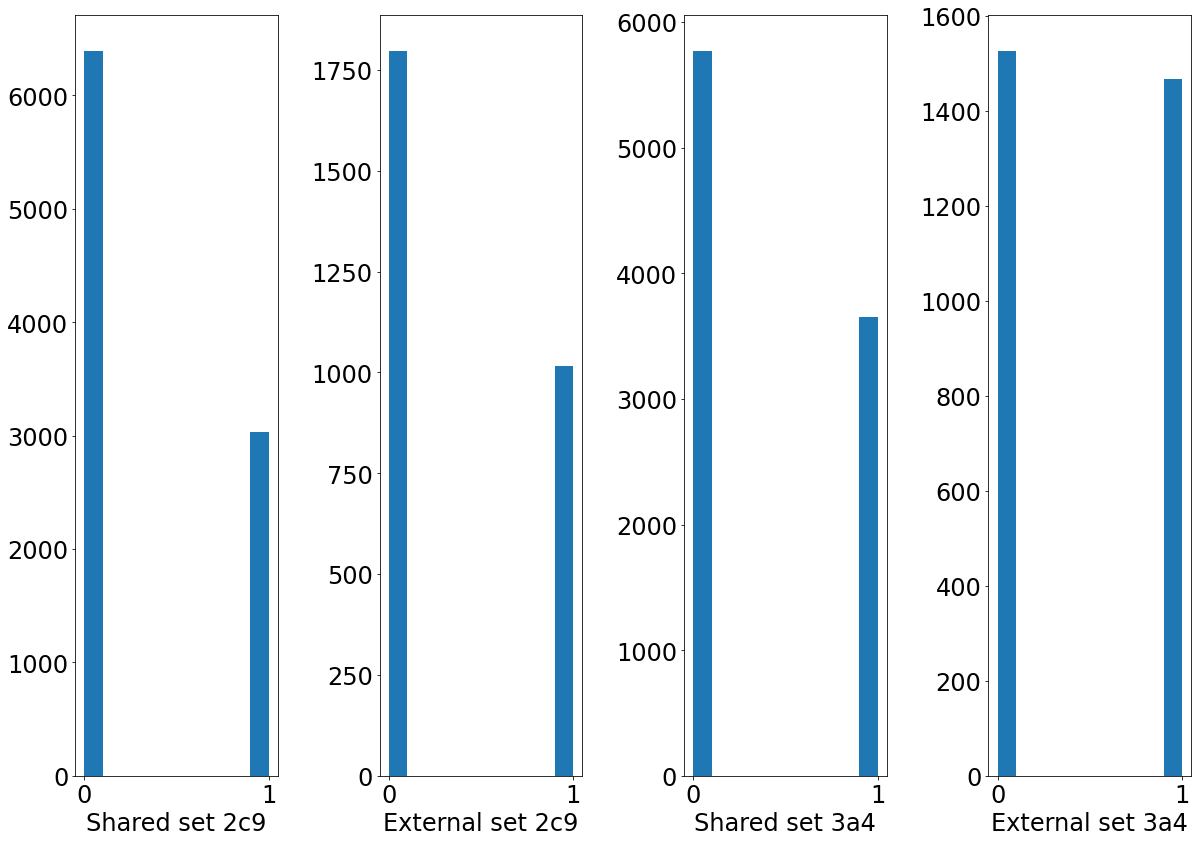

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(20,14))
ax[0].hist(labels_2c9)
ax[0].set_xlabel("Shared set 2c9")
ax[1].hist(labels_testing_2c9)
ax[1].set_xlabel("External set 2c9")
ax[2].hist(labels_3a4)
ax[2].set_xlabel("Shared set 3a4")
ax[3].hist(labels_testing_3a4)
ax[3].set_xlabel("External set 3a4")
plt.subplots_adjust(wspace=0.5)

We start fitting a model to the 2c9 isoform only, with 25% of the data to the test set, we will use the other 2c9 data set as validation.

In [99]:
def get_features(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = []
    for mol in structures_shared:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp,arr)
        features.append(arr)
    return np.array(features)

def print_metrics(predicted_values, target_values):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Accuracy: {accuracy:.3f}, MCC: {mcc:.3f}")

In [6]:
if os.path.exists(os.path.join("features", "shared_set_features.npy")):
    features_shared = np.load(os.path.join("features", "shared_set_features.npy"))
else:
    features_shared = get_features(os.path.join(PATH_DATA, "shared_set_cyp.sdf"))
    np.save(os.path.join("features", "shared_set_features.npy"), features_shared)
    
if os.path.exists(os.path.join("features", "only_2c9_set_features.npy")):
    features_only_2c9 = np.load(os.path.join("features", "only_2c9_set_features.npy"))
else:   
    features_only_2c9 = get_features(os.path.join(PATH_DATA, "only_2c9_set_cyp.sdf"))
    np.save(os.path.join("features", "only_2c9_set_features.npy"), features_only_2c9)
    
if os.path.exists(os.path.join("features", "only_3a4_set_features.npy")):
    features_only_3a4 = np.load(os.path.join("features", "only_3a4_set_features.npy"))
else:   
    features_only_3a4 = get_features(os.path.join(PATH_DATA, "only_3a4_set_cyp.sdf"))
    np.save(os.path.join("features", "only_3a4_set_features.npy"), features_only_3a4)

(7065, 1024) (2355, 1024) (7065,) (2355,)


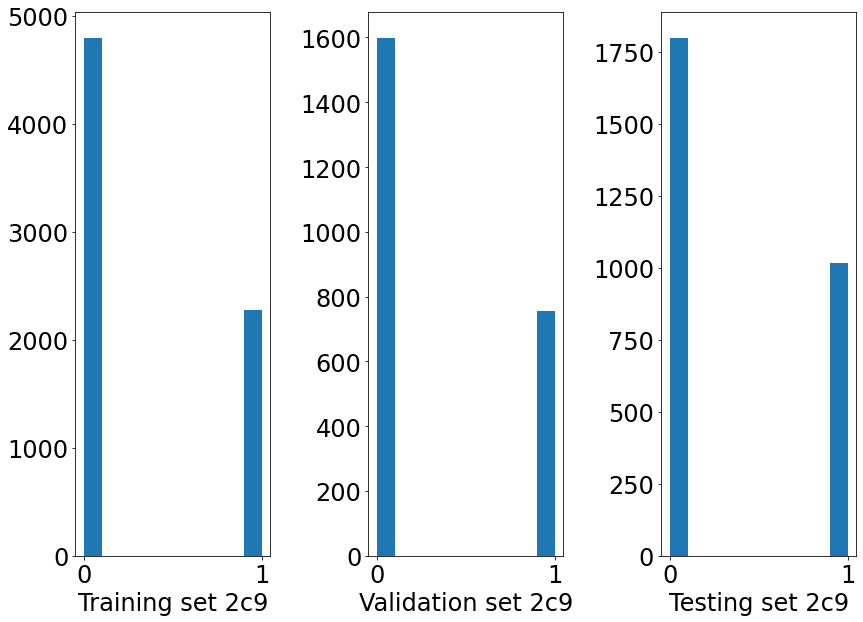

In [7]:
full_train_data, full_test_data, full_train_labels, full_test_labels = train_test_split(features_shared, labels_2c9, stratify=labels_2c9, random_state=1)
print(full_train_data.shape, full_test_data.shape, full_train_labels.shape, full_test_labels.shape)
fig, ax = plt.subplots(1, 3, figsize=(14,10))
ax[0].hist(full_train_labels)
ax[0].set_xlabel("Training set 2c9")
ax[1].hist(full_test_labels)
ax[1].set_xlabel("Validation set 2c9")
ax[2].hist(labels_testing_2c9)
ax[2].set_xlabel("Testing set 2c9")
plt.subplots_adjust(wspace=0.5)

Getting a random smaller dataset

Per mi tindria més sentit que la NN estigues entrenada amb molecules que poden ser actives per una única isoforma i veure que passa amb el shared, ja que es més dificil trobar coses que funcionin per un que no pas que funcionin per 2.

In [8]:
dataset_size = 500                  # training + validation sets
testset_size = int(0.25 * dataset_size)  # To have the same #examples in the test and validation set (Assuming that the mini_dataset will be split 75% train/25%val.)
m_shared = features_shared.shape[0] # number of examples in the whole shared dataset
m_only_2c9 = testing_2c9_data.shape[0] # number of examples in the testing_2c9_data
np.random.seed(2)

# Step 1: Shuffle (X, Y)
permutation_shared = list(np.random.permutation(m_shared))
shuffled_features_shared = features_shared[permutation_shared,:]
shuffled_labels_2c9 = labels_2c9[permutation_shared]
shuffled_labels_3a4 = labels_3a4[permutation_shared]

mini_dataset_shared =  shuffled_features_shared[:dataset_size,:]
mini_labels_2c9 = shuffled_labels_2c9[:dataset_size].reshape(dataset_size,1)
mini_labels_3a4 = shuffled_labels_3a4[:dataset_size].reshape(dataset_size,1)

permutation_only_2c9 = list(np.random.permutation(m_only_2c9))
shuffled_testing_2c9_data = testing_2c9_data.to_numpy()[permutation_only_2c9,:]
shuffled_labels_testing_2c9 = labels_testing_2c9[permutation_only_2c9]

mini_testing_2c9_data = shuffled_testing_2c9_data[:testset_size,:]
mini_labels_testing_2c9_data = shuffled_labels_testing_2c9[:testset_size].reshape(testset_size,1)

(375, 1024) (125, 1024) (375, 1) (125, 1)


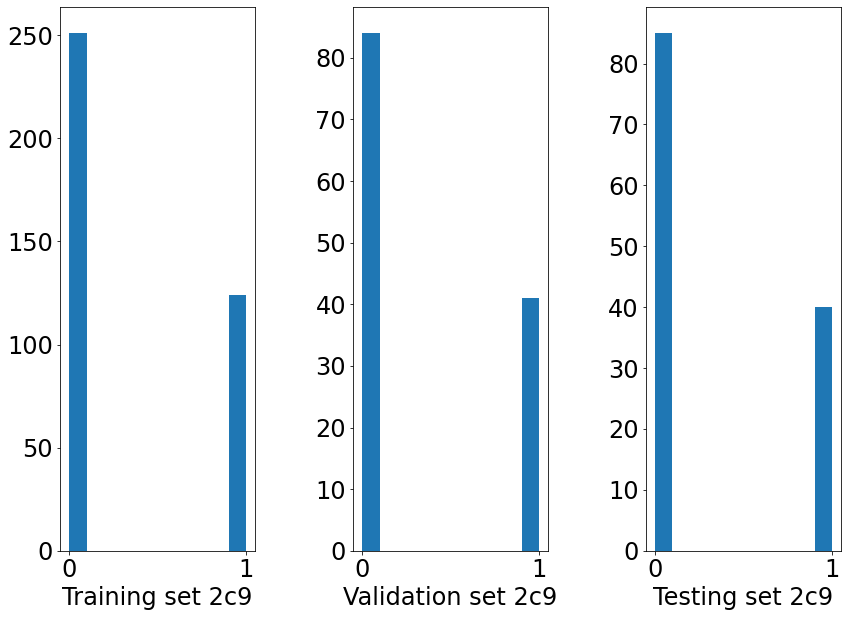

In [9]:
train_data, test_data, train_labels, test_labels = train_test_split(mini_dataset_shared, mini_labels_2c9, stratify=mini_labels_2c9, random_state=1)
print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)
fig, ax = plt.subplots(1, 3, figsize=(14,10))
ax[0].hist(train_labels)
ax[0].set_xlabel("Training set 2c9")
ax[1].hist(test_labels)
ax[1].set_xlabel("Validation set 2c9")
ax[2].hist(mini_labels_testing_2c9_data)
ax[2].set_xlabel("Testing set 2c9")
plt.subplots_adjust(wspace=0.5)

### 2.1 - Create placeholders

Your first task is to create placeholders for `X` and `Y`. This will allow you to later pass your training data in when you run your session. 

**Exercise:** Implement the function below to create the placeholders in tensorflow.

In [10]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "tf.float32"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "tf.float32"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32,shape=[n_x, None], name='X')
    Y = tf.placeholder(tf.float32,shape=[n_y, None], name='Y')
    
    return X, Y

### 2.2 - Initializing the parameters

Your second task is to initialize the parameters in tensorflow.

**Exercise:** Implement the function below to initialize the parameters in tensorflow. You are going use Xavier Initialization for weights and Zero Initialization for biases. The shapes are given below. As an example, to help you, for W1 and b1 you could use: 

```python
W1 = tf.get_variable("W1", [25,12288], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
```
Please use `seed = 1` to make sure your results match ours.

In [11]:
def initialize_parameters_deep(layer_dims):
    """
 Given the layers dimensions, generates all the initial parameters W (Xavier initialisation for ReLu) and b (zeros).
    :param layer_dims: python array or list containing the dimensions of each layer in our network
    :return:
        parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    tf.set_random_seed(1)  # to compare data
    
    parameters = {}
    L = len(layer_dims)  # number of layers in the network
    for l in range(1, L):
        parameters[f'W{l}'] = tf.get_variable(f'W{l}', [layer_dims[l], layer_dims[l - 1]], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
        parameters[f'b{l}'] = tf.get_variable(f'b{l}', [layer_dims[l], 1], initializer = tf.zeros_initializer())
        assert (parameters[f'W{l}'].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters[f'b{l}'].shape == (layer_dims[l], 1))
    return parameters

### 2.3 - Forward propagation in tensorflow 

You will now implement the forward propagation module in tensorflow. The function will take in a dictionary of parameters and it will complete the forward pass. The functions you will be using are: 

- `tf.add(...,...)` to do an addition
- `tf.matmul(...,...)` to do a matrix multiplication
- `tf.nn.relu(...)` to apply the ReLU activation

**Question:** Implement the forward pass of the neural network. We commented for you the numpy equivalents so that you can compare the tensorflow implementation to numpy. It is important to note that the forward propagation stops at `z3`. The reason is that in tensorflow the last linear layer output is given as input to the function computing the loss. Therefore, you don't need `a3`!



In [13]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer
    
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns
    A -- the output of the activation function, also called the post-activation value
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    if activation == "sigmoid":
        Z = tf.add(tf.matmul(W,A_prev), b)
        A = tf.math.sigmoid(Z)
    elif activation == "relu":
        Z = tf.add(tf.matmul(W,A_prev), b)
        A = tf.nn.relu(Z)
    #assert (A.shape == (W.shape[0], A_prev.shape[1]))
    return A

In [14]:
def forward_propagation_deep(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"...
                  the shapes are given in initialize_parameters

    Returns:
    ZL -- the output of the last LINEAR unit
    """

    A = X
    L = len(parameters) // 2  # number of layers in the neural network
    for l in range(1, L):
        A_prev = A
        A = linear_activation_forward(A_prev, parameters[f'W{l}'], parameters[f'b{l}'],activation='relu')
    ZL = tf.add(tf.matmul(parameters[f'W{L}'],A), parameters[f'b{L}'])
    #assert (ZL.shape == (1, X.shape[1]))
    return ZL

### 2.4 Compute cost

As seen before, it is very easy to compute the cost using:
```python
tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ..., labels = ...))
```
**Question**: Implement the cost function below. 
- It is important to know that the "`logits`" and "`labels`" inputs of `tf.nn.softmax_cross_entropy_with_logits` are expected to be of shape (number of examples, num_classes). We have thus transposed Z3 and Y for you.
- Besides, `tf.reduce_mean` basically does the summation over the examples.

In [15]:
def compute_cost_binary(ZL, Y):
    """
    Computes the cost for binary classification
    
    Arguments:
    ZL -- output of forward propagation (output of the last LINEAR unit), of shape (1, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(ZL)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = labels))
    #cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

### 2.5 - Backward propagation & parameter updates

This is where you become grateful to programming frameworks. All the backpropagation and the parameters update is taken care of in 1 line of code. It is very easy to incorporate this line in the model.

After you compute the cost function. You will create an "`optimizer`" object. You have to call this object along with the cost when running the tf.session. When called, it will perform an optimization on the given cost with the chosen method and learning rate.

For instance, for gradient descent the optimizer would be:
```python
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
```

To make the optimization you would do:
```python
_ , c = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
```

This computes the backpropagation by passing through the tensorflow graph in the reverse order. From cost to inputs.

**Note** When coding, we often use `_` as a "throwaway" variable to store values that we won't need to use later. Here, `_` takes on the evaluated value of `optimizer`, which we don't need (and `c` takes the value of the `cost` variable). 

### 2.6 - Building the model

Now, you will bring it all together! 

**Exercise:** Implement the model. You will be calling the functions you had previously implemented.

In [16]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [18]:
def model_simple_dnn(layer_dim, X_train, Y_train, X_test, Y_test, lr = 0.0001,
          num_epochs = 20, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    layer_dim -- list containing the size of the layers
    X_train -- training set, of shape (input size = 1024, number of training examples = 325)
    Y_train -- test set, of shape (output size = 1, number of training examples = 325)
    X_test -- training set, of shape (input size = 1024, number of training examples = 125)
    Y_test -- test set, of shape (output size =1, number of test examples = 125)
    lr -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters_deep(layer_dim)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ZL = forward_propagation_deep(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost_binary(ZL, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 10 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(lr))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(ZL), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        return parameters

Run the following cell to train the model!

In [19]:
train_data=train_data.T
train_labels=train_labels.T
test_data=test_data.T
test_labels=test_labels.T

print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

(1024, 375) (1, 375) (1024, 125) (1, 125)


Cost after epoch 0: 0.255097
Cost after epoch 10: 0.235804


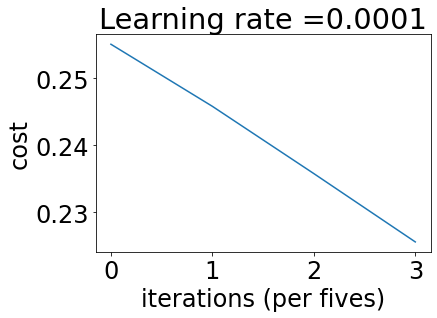

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 1.0


In [20]:
parameters = model_simple_dnn([1024, 10,5,1],train_data, train_labels, test_data, test_labels)

In [90]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    :param X: data set of examples we want to label
    :param y: labels for the examples (0 order, 1 disorder)
    :param parameters: parameters of the trained model
    :return:
        p -- predictions for the given dataset X
        accuracy -- number of right preditions divided by the number of examples
    """
    m = X.shape[1]
    n = len(parameters) // 2  # number of layers in the neural network
    p = np.zeros((1, m))
    ZL= forward_propagation_deep(X, parameters)
    prob = tf.sigmoid(ZL)
    with tf.Session() as sess:
        prob = sess.run(prob)
    prob=np.squeeze(prob)
    #prob=np.reshape(prob, (1,m))
    print(prob[0],prob.shape, type(prob))
    # convert prob to 0/1 predictions
    for i in range(0, m):
        if prob[i] > 0.5:
            p[0, i] = 1
        else:
            p[0, i] = 0
    #accuracy = np.sum((p == y) / m)
    return p#, accuracy

In [93]:
train_data=tf.cast(train_data, "float32")
p_train= predict(train_data, train_labels, parameters)
print(p_train.shape)

0.37690574 (375,) <class 'numpy.ndarray'>
(1, 375)


In [97]:
train_labels.shape

(1, 375)

In [100]:
print_metrics(np.squeeze(p_train), np.squeeze(train_labels))


NER: 0.520, Sensitivity or recall: 0.040, Specificity: 1.000, Precision: 1.000, Accuracy: 0.683, MCC: 0.165
